<a href="https://colab.research.google.com/github/dlevonian/cc-fraud-detection/blob/master/ulb_cc_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup & EDA

### Objectives

The dataset is from the [Credit Card Fraud Detection at Kaggle](https://www.kaggle.com/mlg-ulb/creditcardfraud). It contains transactions made by credit cards in September 2013 by european cardholders: 492 frauds out of 284,807 transactions.

The business objective of a fraud detection system is essentially finding the **optimal sensitivity of the fraud filter to maximize its economic benefits**. Avoiding every single fraudulent transaction at all cost is far from optimal.

"The most immediate threat to merchants when it comes to false positives is revenue loss. Javelin reports that U.S. merchants lose nearly $118 billion each year to falsely declined transactions, which amounts to more than 13 times as much as the cost of credit card fraud." (from [The Financial Impact of False Positives on e-Commerce Fraud Detection](https://blog.clear.sale/the-financial-impact-of-false-positives-on-e-commerce-fraud-detection))

More useful links:

[Reducing false positives in credit card fraud detection](https://www.sciencedaily.com/releases/2018/09/180920131513.htm)

[A primer on machine learning for fraud detection](https://stripe.com/radar/guide)



This notebook optimizes the economic objective **for the merchants** since they carry the eventual economic cost of fraud. The economic objectives of a bank or a payment operator may differ from the merchants. 

For the merchant, the Net Gain (total economic effect) from the fraud detector has 2 components:
1. For each correctly identified fraud (True Positives), the merchant saves the marginal cost of goods sold (COGS) per unit + chargeback(dispute) fee. Chargeback fees can be large (€15 and more), which is significant compared to a median transaction of €22
2. For each incorrectly blocked legitimate transaction (False Positives), the merchant loses the net margin per unit, but only for those FP that are not eventually recovered (eg customer calling to unblock) and are truly lost business. In addition, there are potential extra costs (externalities) such as annoyed customers switching to competitors


Each classifier (filter) below finds the optimal sensitivity to maximize the Net Gain:

![alt text](https://drive.google.com/uc?id=1WC4nKQ_8raXd4QKstLq3Op5zeVHIGTSe)

Assumptions:
- Margins:   5%, 20%
- Chargeback: flat €15 per transaction
- Lost, the share of FP that do not recover = 50%
- TP externalities such as lost customers = 0    






In [2]:
# economic parameters
MARGIN      = 0.20
CHARGEBACK  = 15
LOST        = 0.5
EXT         = 0

### Imports, Load

In [3]:
import pandas as pd
import numpy as np

import scipy
import math
import time

import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('ggplot')

import warnings
warnings.simplefilter(action='ignore')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [4]:
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import make_scorer, confusion_matrix, classification_report,\
                            roc_curve, roc_auc_score, average_precision_score
from sklearn import svm
from xgboost import XGBClassifier

In [5]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import Constant

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import Precision, Recall, AUC

In [6]:
SEED=2020
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = '/content/drive/My Drive/Fraud_detection/'

Mounted at /content/drive


In [8]:
df = pd.read_csv(path+'data/creditcard.csv')
print(df.shape)

(284807, 31)


In [9]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
211253,138331.0,-0.424849,1.440450,1.144727,2.770542,1.274736,-0.266094,1.160302,-0.151599,-1.942956,0.649006,-1.297299,0.073363,1.165797,-0.124062,-1.486308,0.614403,-0.906942,-0.371149,-1.706106,-0.112490,0.270038,0.812179,-0.253067,0.072351,-0.149161,0.011216,0.139467,0.183261,1.71,0
216519,140515.0,1.923825,-0.285707,-1.730333,-0.046817,1.372527,1.705817,-0.140174,0.363828,0.511349,-0.160968,-0.455742,0.855811,0.678516,0.185762,0.898574,-1.310042,0.685846,-2.631184,-1.056752,-0.257473,-0.173432,-0.196649,0.340552,-1.285473,-0.372171,0.412211,-0.005250,-0.075931,10.60,0
280714,169705.0,1.928541,-0.338794,-0.773928,1.023823,0.027824,0.601129,-0.608708,0.282794,0.857511,0.376208,-0.058585,0.136016,-1.096098,0.377965,-0.058470,0.642468,-1.017357,0.948728,-0.121239,-0.242521,0.156631,0.482619,0.086723,-0.016709,-0.023490,-0.589910,0.033751,-0.042676,25.00,0
92856,64140.0,0.990399,-0.162846,1.256590,1.277200,-0.825194,0.305162,-0.672139,0.328584,0.567870,-0.077904,0.152274,0.013643,-0.775626,0.221115,1.986134,0.033850,0.024550,-0.570541,-1.557875,-0.169263,0.194705,0.538353,0.071150,0.061135,0.104104,-0.323222,0.082969,0.041972,45.00,0
168088,119061.0,1.777328,-0.153731,0.443905,3.522905,-0.299301,1.604670,-1.216280,0.615849,-0.005621,1.534559,-0.450045,-0.424607,-0.937974,-0.096456,-0.489811,2.154432,-1.605501,1.294811,-1.447697,-0.212798,0.233492,0.552009,0.197448,0.020809,-0.479260,-0.041677,0.024602,-0.023316,37.83,0


### EDA, preprocess

In [10]:
# Vx features, product of a PCA, are mean-centered
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [11]:
# Number of transactions in each class, fraud ratio
print(df.Class.value_counts())
print(f'{df.Class.mean():.6f}  {1/df.Class.mean():.1f}')

0    284315
1       492
Name: Class, dtype: int64
0.001727  578.9


In [12]:
# Value of transactions  in each class
# Fraud has a bigger share of the amount (0.24%) than of the count (0.17%)

total_amount = df.Amount.sum()
fraud_amount = df.Amount[df.Class==1].sum()

# net loss if no fraud filter is installed:
net_loss = (1-MARGIN)*sum(df.Amount[df.Class==1]) + CHARGEBACK*sum(df.Class)

print(f'Total amount:           € {total_amount:,.0f}')
print(f'Total amount of fraud:  € {fraud_amount:,.0f}     {100*fraud_amount/total_amount:.3f}% of total')
print(f'Net loss if no filter:  € {net_loss:,.0f}')

Total amount:           € 25,162,590
Total amount of fraud:  € 60,128     0.239% of total
Net loss if no filter:  € 55,482


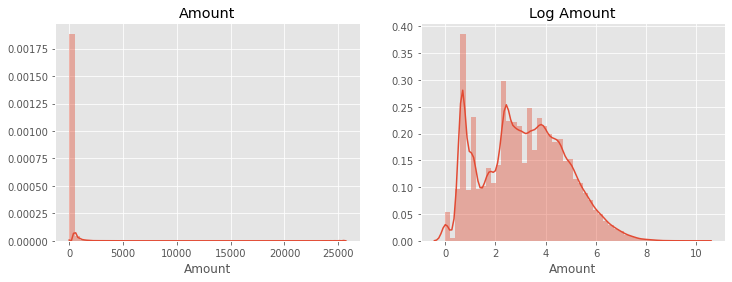

In [13]:
# Log transformation of Amount
_, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
sns.distplot(df.Amount, ax=ax0)
ax0.set_title('Amount')
sns.distplot(np.log1p(df.Amount), ax=ax1)
ax1.set_title('Log Amount')
plt.show()

In [14]:
# Log transform the price, create a new variable
# Leave the original EUR amount to assess the economic effect of filtering
df['logamount'] = np.log1p(df.Amount)

# Scale time to days: time->time/86_400
df.Time = df.Time/86_400

In [15]:
df.sample(5)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,logamount
228026,1.682037,0.459711,1.320846,0.198472,4.616557,0.127274,1.255800,-1.094343,-2.465487,-1.988245,1.361739,-0.106351,-0.663393,-1.799056,1.327093,-0.087655,0.240072,0.043401,0.991955,1.084524,0.681026,-0.926620,1.402564,-0.184959,-0.339276,0.354032,0.700116,0.176191,0.302403,10.62,0,2.452728
75832,0.651308,-0.361501,0.981428,0.850195,0.729616,0.147607,-0.227926,0.780035,-0.027560,-0.643813,0.283402,0.961861,0.580380,0.200316,0.383220,0.347748,-0.002013,-0.601575,0.659971,0.754614,0.127468,0.129948,0.504925,-0.075203,0.017612,-0.088984,-0.320768,0.237501,0.107966,49.15,0,3.915019
242811,1.755382,-1.095266,-0.022863,0.891870,-3.399573,1.130284,4.255068,-1.557874,1.792778,-0.644386,-0.489840,-0.452097,-0.739687,0.093451,-0.545031,0.417642,1.864390,-0.231775,-0.683996,-0.521894,0.147563,0.407116,1.012257,-0.375939,0.730568,0.575140,-0.010707,0.205619,0.056808,0.02,0,0.019803
97921,0.768993,0.003842,0.047011,0.367682,-2.008896,0.293528,-0.331976,0.394356,-0.102658,-1.550192,0.288224,0.330618,0.038026,1.157530,-0.244047,-0.917500,1.616564,-0.742806,-0.554700,0.525418,0.158640,0.415560,1.066429,-0.073803,-0.667590,-0.704712,-0.430117,0.198688,0.209581,39.63,0,3.704507
45564,0.490799,1.377375,-1.275557,0.752324,-1.357240,-1.961013,-0.747075,-1.256052,0.053464,-1.735192,1.621585,1.137196,-1.075244,-1.446890,0.206851,0.247148,0.039702,0.356765,0.579595,-0.025452,-0.369328,-0.304342,-0.730233,0.184129,0.428006,-0.001770,-0.437295,0.020919,0.023623,47.40,0,3.879500


Visualize the features

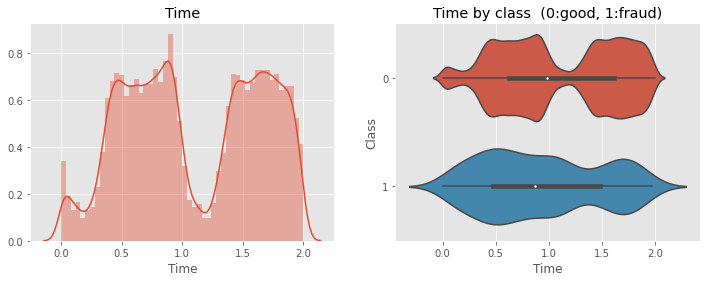

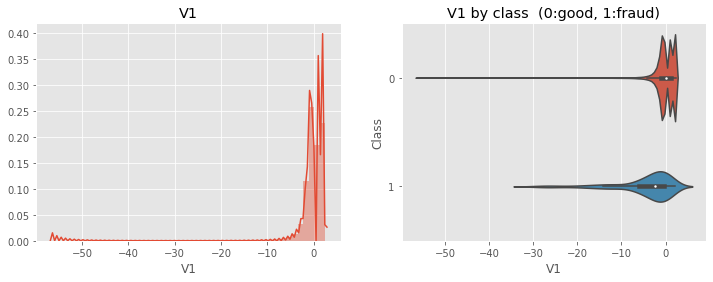

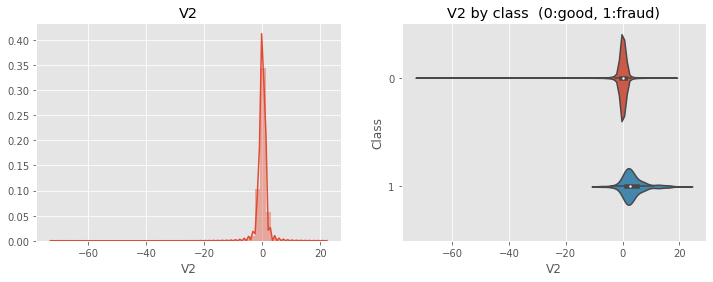

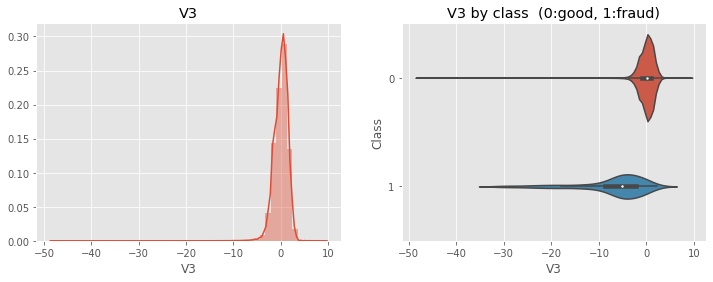

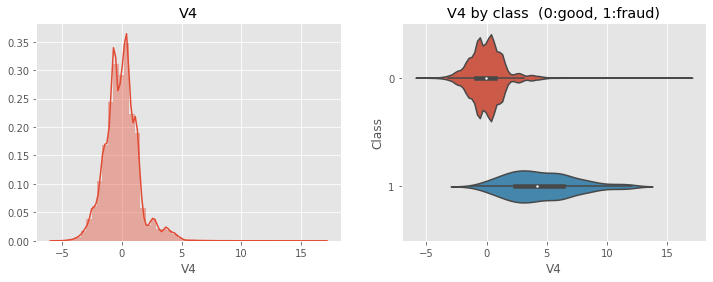

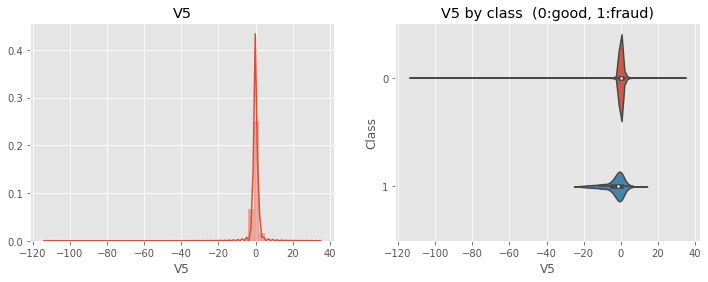

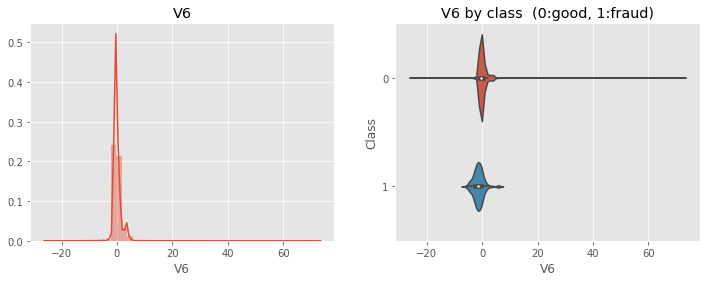

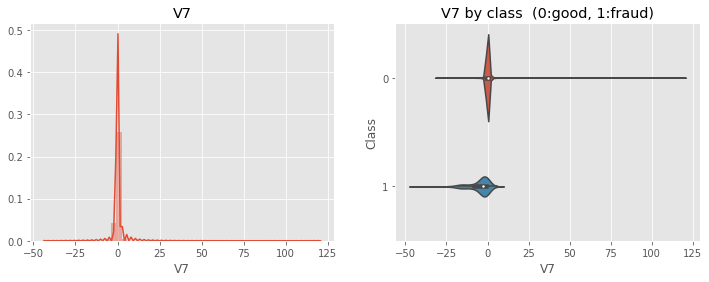

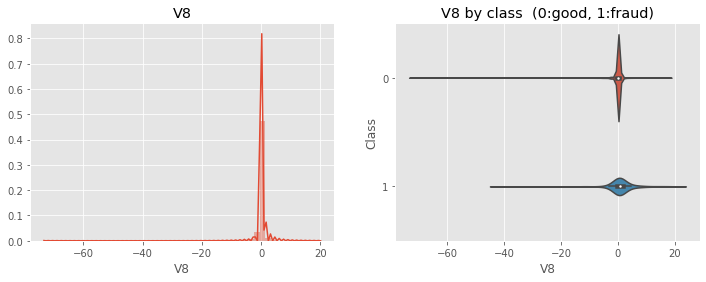

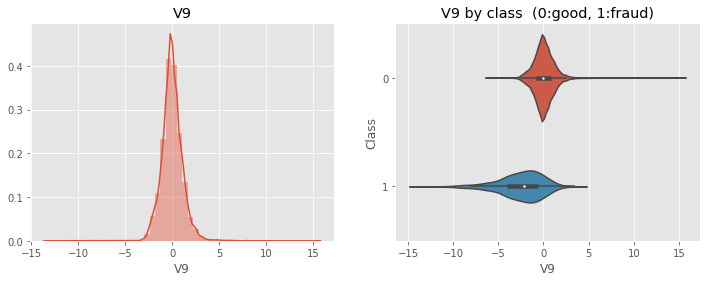

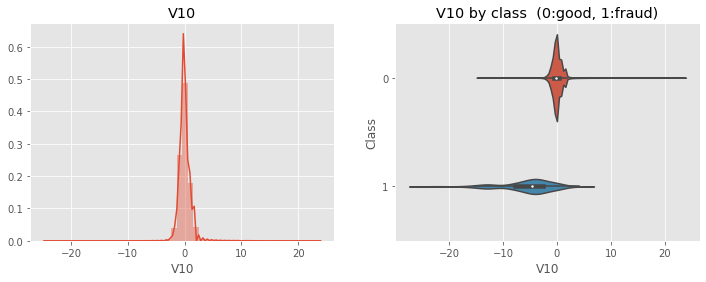

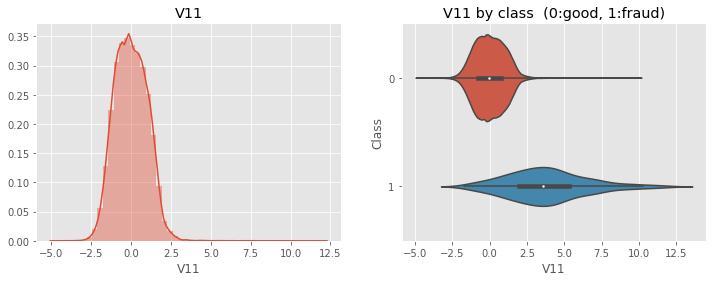

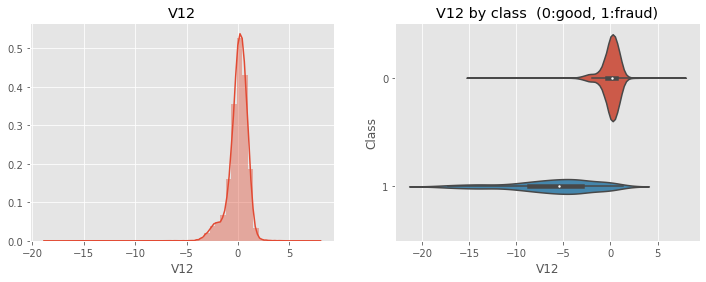

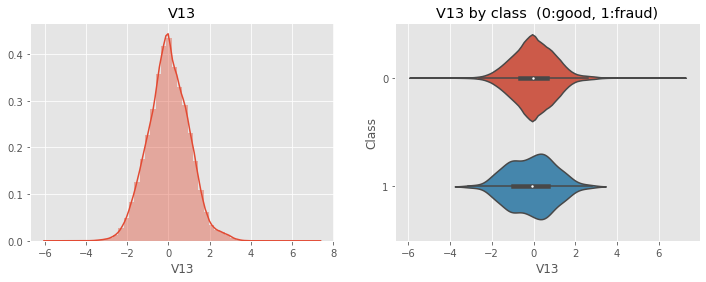

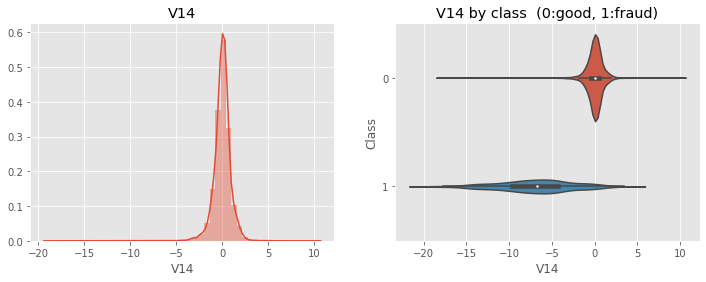

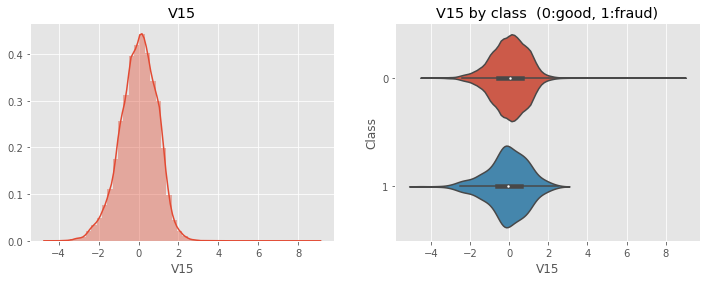

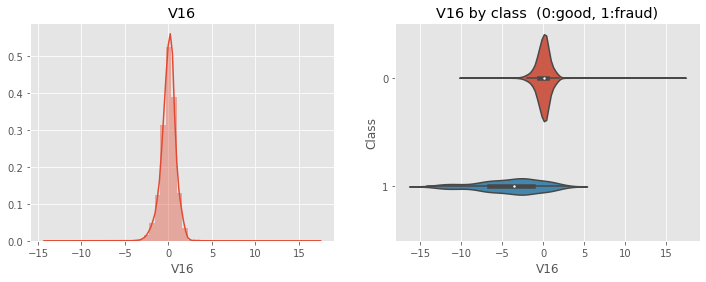

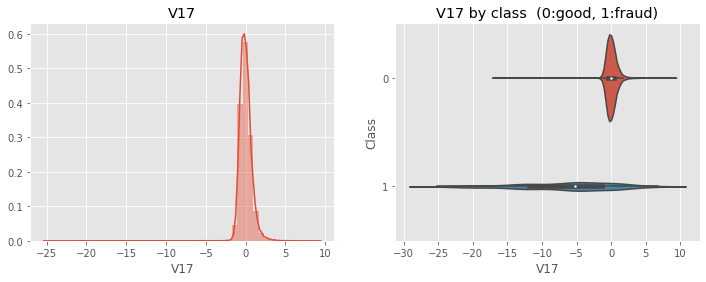

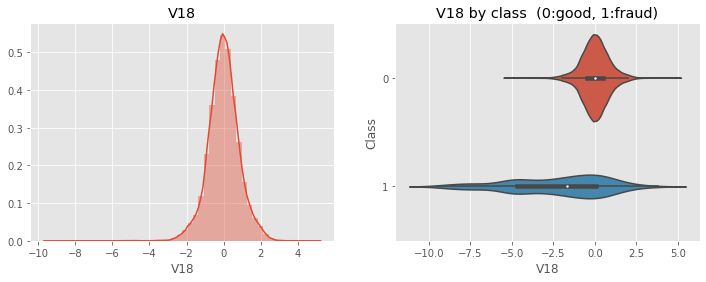

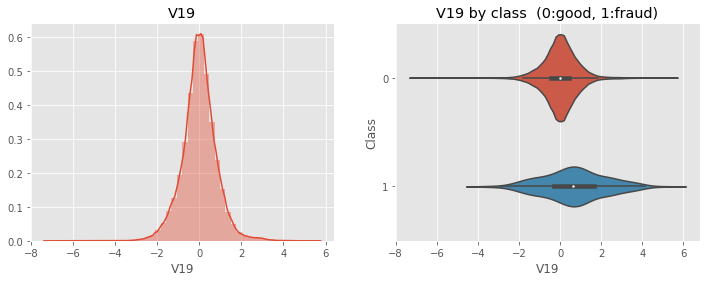

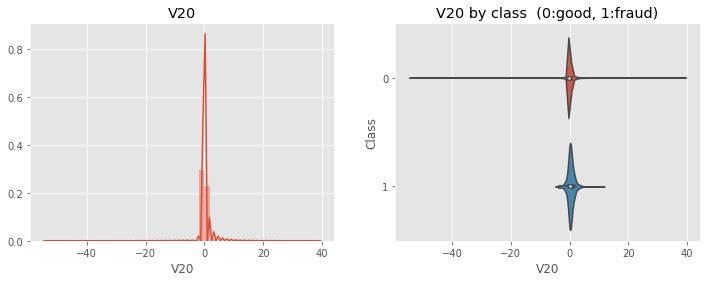

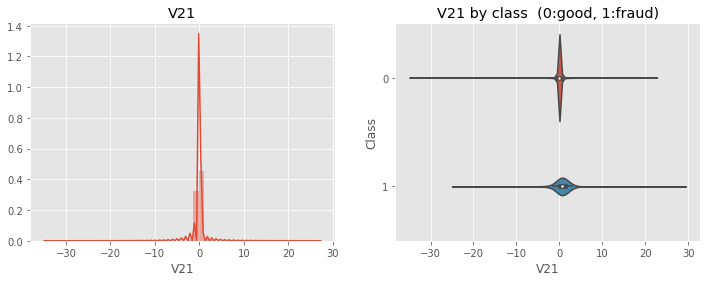

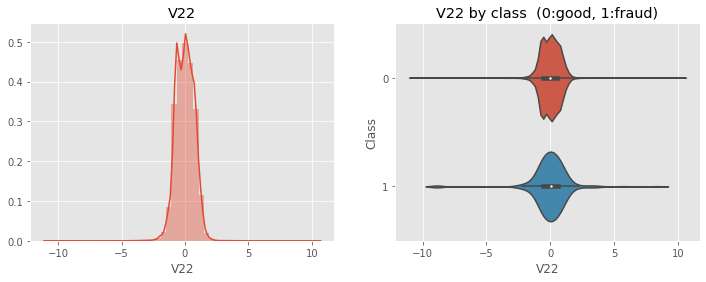

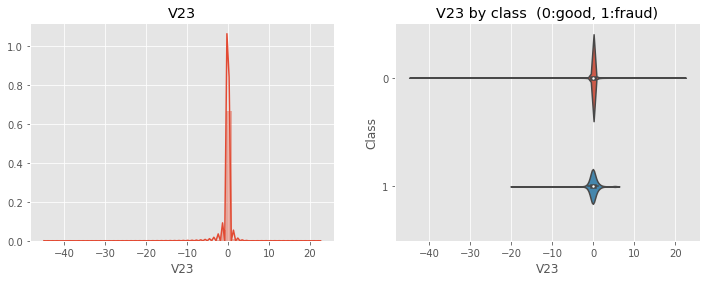

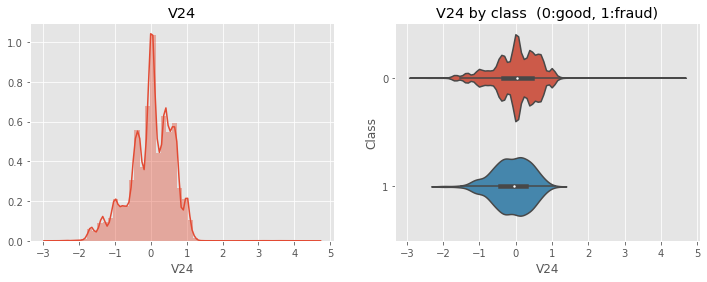

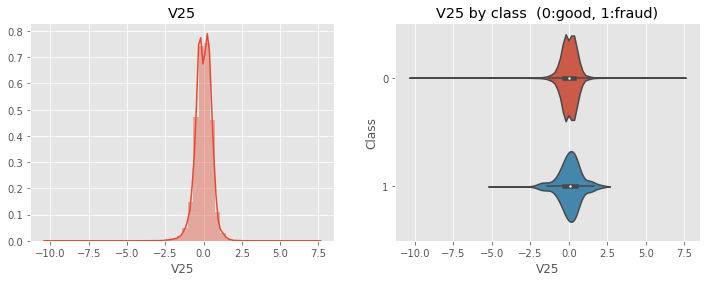

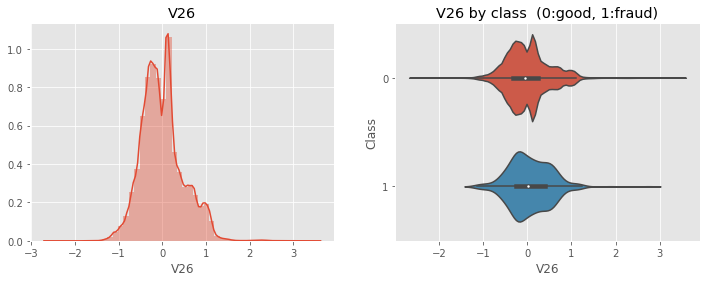

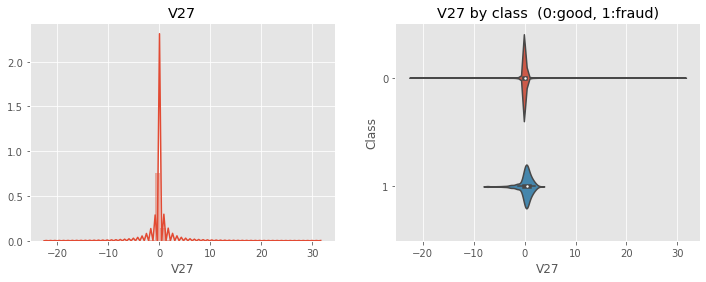

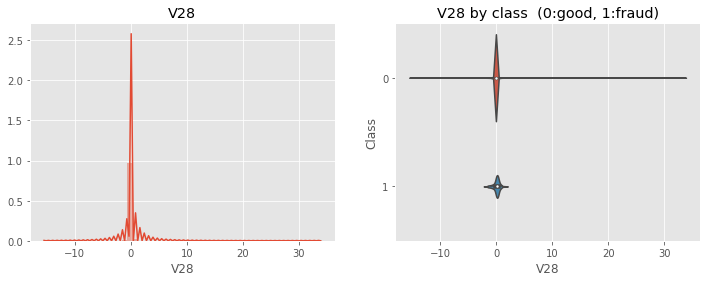

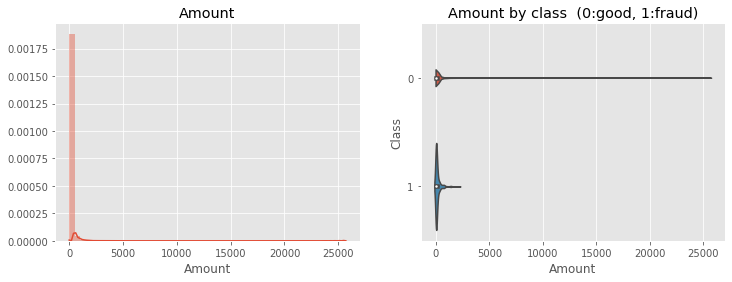

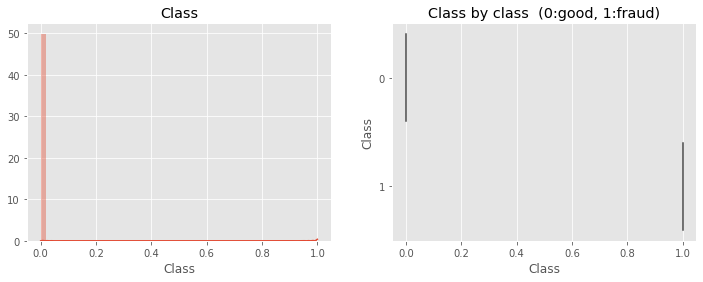

In [16]:
def plot_feature(f):
    _, (ax0,ax1) = plt.subplots(1, 2, figsize=(12, 4))
    sns.distplot(df[f], ax=ax0)
    ax0.set_title(f)
    sns.violinplot(f,'Class',data=df, orient='h', ax=ax1)
    ax1.set_title(f'{f} by class  (0:good, 1:fraud)')
    plt.show()

for f in df.columns[:-1]:
    plot_feature(f)

### Correlations

Explore correlations, sort features by importance

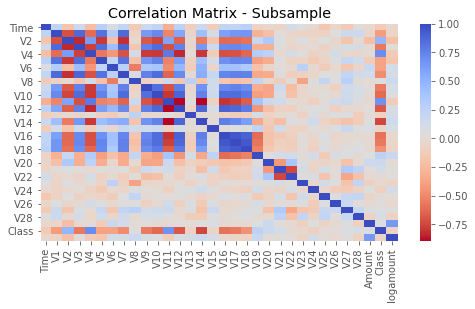

In [17]:
# downsample good transactions to equal the fraud count to make correlation coeffs. more salient
sub_df = pd.concat([df[df.Class==1], df[df.Class==0].sample(sum(df.Class), random_state=SEED)], axis=0)
plt.figure(figsize=(8,4))
sns.heatmap(sub_df.corr(), cmap='coolwarm_r')
plt.title('Correlation Matrix - Subsample')
plt.show()

In [18]:
# feature importance
fi = scipy.stats.ttest_ind(sub_df[sub_df.Class==0], sub_df[sub_df.Class==1], equal_var=False)
fi = pd.DataFrame(data={'corr':sub_df.corr().Class, 'pvalue':fi[1]}).sort_values(by='corr', ascending=False)
fi

,corr,pvalue
Class,1.000000,0.000000e+00
V4,0.706196,2.461030e-136
V11,0.688442,1.954372e-122
V2,0.485108,1.413723e-56
V19,0.254957,6.350646e-16
V20,0.167259,1.334520e-07
V21,0.129959,4.646305e-05
V28,0.096494,2.448578e-03
V27,0.071752,2.453931e-02
Amount,0.062673,4.936945e-02


There are only a few features (V8, 15, 22, 23, 25, 26) which fall below significance (>5% pvalue) in t-test. However, removing these features proves to be detrimental for the model performance -- indication of non-linear relationship and/or feature interaction effects. 

Conclusion: leave all the features

In [19]:
# tried eliminating low-correlated features -> model performance deteriorates!
elim_cols = fi[fi.pvalue>0.05].index.sort_values().tolist()
print(elim_cols)

# df = df.drop(elim_cols, axis=1)
df.head()

['V15', 'V22', 'V23', 'V25', 'V26', 'V8']


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,logamount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.014760
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.305626
2,0.000012,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.939276
3,0.000012,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.824306
4,0.000023,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.262539


### Train/test Split

In [20]:
TEST_SIZE = 0.2

X_train, X_test = train_test_split(df, test_size=TEST_SIZE, random_state=SEED)

print('train shape: ', X_train.shape)
print(X_train.Class.value_counts())
print(f'{X_train.Class.mean():.6f}  {1/X_train.Class.mean():.1f}')
print(50*'-')
print('test shape: ', X_test.shape)
print(X_test.Class.value_counts())
print(f'{X_test.Class.mean():.6f}  {1/X_test.Class.mean():.1f}')

train shape:  (227845, 32)
0    227446
1       399
Name: Class, dtype: int64
0.001751  571.0
--------------------------------------------------
test shape:  (56962, 32)
0    56869
1       93
Name: Class, dtype: int64
0.001633  612.5


In [21]:
# Freeze TEST
A_test = X_test.pop('Amount') # will be used later to assess the economic effect of filtering
Y_test = X_test.pop('Class')

In [22]:
# G is the ratio of good:bad transactions to be left in the training set. 
# G does not have to be 1:1, optimize empirically -> G=10 is better

G = 10

X_train = pd.concat([X_train[X_train.Class==1],
                    X_train[X_train.Class==0].sample(G*sum(X_train.Class), random_state=SEED)
                    ], axis=0)

print('Subsampled train shape: ', X_train.shape)
print(X_train.Class.value_counts())
print(f'{X_train.Class.mean():.6f}  {1/X_train.Class.mean():.1f}')


Subsampled train shape:  (4389, 32)
0    3990
1     399
Name: Class, dtype: int64
0.090909  11.0


In [23]:
# Freeze TRAIN
A_train = X_train.pop('Amount') # will be used later to assess the economic effect of filtering
Y_train = X_train.pop('Class')

### t-SNE
2d embedding of the Train set:

In [24]:
def plot_tsne(X_emb, Y):
    plt.figure(figsize=(10, 8))
    plt.scatter(X_emb[np.where(Y==0), 0], X_emb[np.where(Y==0), 1], marker='.', color='g', alpha=1, label='Non Fraud')
    plt.scatter(X_emb[np.where(Y==1), 0], X_emb[np.where(Y==1), 1], marker='o', color='r', alpha=0.5, label='Fraud')
    plt.title('t-SNE embedding')
    plt.legend(loc='best')
    plt.show()

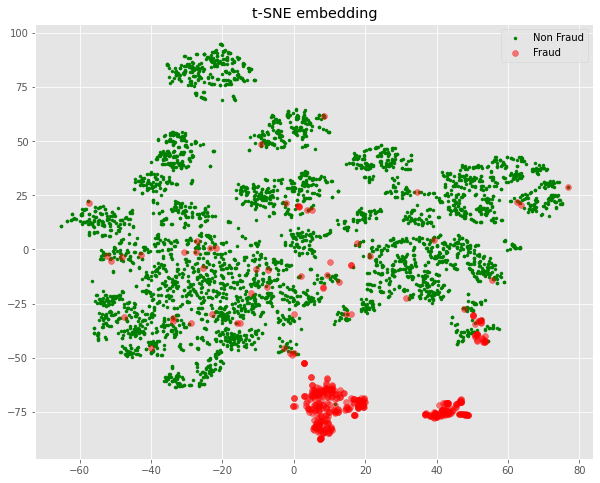

In [25]:
tsne = TSNE(n_components=2, random_state=SEED)

X_emb = tsne.fit_transform(X_train)
plot_tsne(X_emb, Y_train)


The vast majority of fraud is nicely separable, but not all of them!

# Classifiers

### Helpers

Standard evaluation - all models should call this methods

In [26]:
# Initialize report dataframe
def new_report():
    return pd.DataFrame(columns=['classifier', 
                                'TN', 'FP', 'FN', 'TP',
                                'AUC', 'AUPRC', 
                                'max_gain',   # maximum net gain achieved at the optimal cutoff threshold
                                              # calculated as % of total gain of a perfect filter
                                'precision', 'recall', 'fpr',  # all for the optimal cutoff threshold
                                ])
reports = new_report()
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr


In [27]:
def threshold_arrays(y_true, y_hat):
    """
    Inputs:
        y, array of int 0/1, ground truth labels for good/fraud
        y_hat, array of float, predicted probabilities of fraud
    Outputs:
        Threshold arrays: thresholds, precision, recall, fpr
    """
    fpr, recall, thresholds = roc_curve(y_true, y_hat)
    thresholds[0]=1  #remedy sklearn's artifact of thresholds[0]>1
    precision = 1/(1+(fpr/recall)*(len(y_true)/sum(y_true)-1)) 
    
    stay = np.full_like(thresholds, True, dtype=bool)
    if len(thresholds)>1_000: # downsize all arrays to size <1_000 (to speed up calculations)
        stay[100:-100] = False         
        stay[100:-100:1+len(thresholds)//1000] = True  # in between, leave only nth element s.t. total len<~1_000

    thresholds, precision, recall, fpr = thresholds[stay], precision[stay], recall[stay], fpr[stay]

    return thresholds, precision, recall, fpr


In [28]:
def optimal_points(y_true, 
                   y_hat, 
                   amount,
                   MARGIN=MARGIN,
                   CHARGEBACK=CHARGEBACK,
                   LOST=LOST,
                   EXT=EXT,
                   ):    
    """
    Inputs: 
        y, array of int 0/1, ground truth labels for good/fraud
        y_hat, array of float, predicted probabilities of fraud
        amount, array of float, amounts in EUR for respective transactions
    Output: 
        Metrics for the optimal point that maximizes the economic effect of the fraud filter:
        opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold
    """
    thresholds, precision, recall, fpr = threshold_arrays(y_true, y_hat)

    net_gain = np.zeros_like(thresholds)
    for i, t in enumerate(thresholds):
        tp = (y_hat>t)*y_true     ==1  # array of Bool - True Positives
        fp = (y_hat>t)*(1-y_true) ==1  # array of Bool - False Positives
        net_gain[i] = (1-MARGIN)*sum(amount[tp]) + CHARGEBACK*sum(tp) - MARGIN*LOST*sum(amount[fp]) - EXT*sum(fp)

    # optimal (maximum) economic gain as % of the gain of a perfect filter (TP=P, FP=0)
    opt_gain = max(net_gain) / ((1-MARGIN)*sum(amount[y_true==1]) + CHARGEBACK*sum(y_true))

    # optimal point metrics
    idx = np.argmax(net_gain)
    opt_precision = precision[idx]
    opt_recall    = recall[idx]
    opt_fpr       = fpr[idx]
    opt_threshold = thresholds[idx]
    
    return opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold

In [29]:
def report(classifier_name, y_hat, y_true=Y_test, amount=A_test):
    """
    Inputs:
        y, array of int 0/1, ground truth labels for good/fraud
        y_hat, array of float, predicted probabilities of fraud
        amount, array of float, amounts in EUR for respective transactions
    Output: 
        report dataframe of 1 row 
    """
    AUC   = roc_auc_score(y_true, y_hat)
    AUPRC = average_precision_score(y_true, y_hat)
    opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold = optimal_points(y_true, y_hat, amount)
    tn, fp, fn, tp = confusion_matrix(y_true, y_hat>opt_threshold).ravel()

    df = new_report()
    df.loc[0] = ([classifier_name, 
                    tn, fp, fn, tp,
                    f'{AUC:.3f}',
                    f'{AUPRC:.3f}',
                    f'{opt_gain:.3f}',
                    f'{opt_precision:.3f}',
                    f'{opt_recall:.3f}',
                    f'{opt_fpr:.6f}',
                    ])
    return df


In [30]:
def plot_classifier(y_hat, y_true=Y_test, amount=A_test):

    thresholds, precision, recall, fpr = threshold_arrays(y_true, y_hat)
    opt_gain, opt_precision, opt_recall, opt_fpr, opt_threshold = optimal_points(y_true, y_hat, amount)
    
    _,(ax0,ax1) = plt.subplots(1, 2, figsize=(12, 5))

    ax0.plot(recall,  precision,  color='c')
    ax0.set_xlabel('recall')
    ax0.set_ylabel('precision')
    ax0.set_title(f'Precision-Recall.  AUPRC={average_precision_score(y_true, y_hat):.3f}')
    ax0.plot((opt_recall), (opt_precision), color='m', marker='o', label='optimal gain')
    ax0.legend(loc='lower left')

    ax1.plot(fpr, recall,  color='c')
    ax1.set_xlabel('false positive rate')
    ax1.set_ylabel('recall')
    ax1.set_title(f'ROC for FRP<1%.  AUC={roc_auc_score(y_true, y_hat):.3f}')
    ax1.plot((opt_fpr), (opt_recall), color='m', marker='o', label='optimal gain')
    ax1.legend(loc='lower right')
    ax1.set_xlim(-0.001,0.01)

    plt.show()

### Logistic Regression

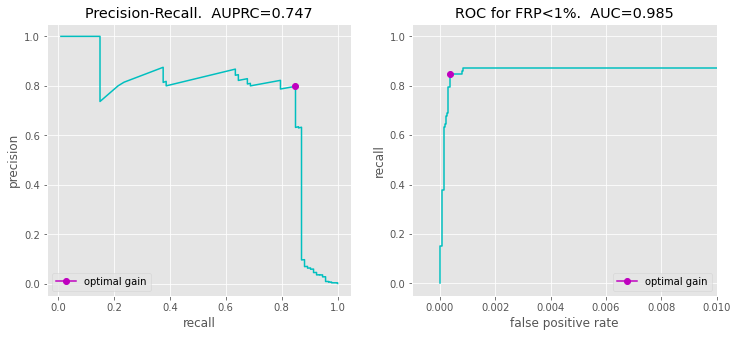

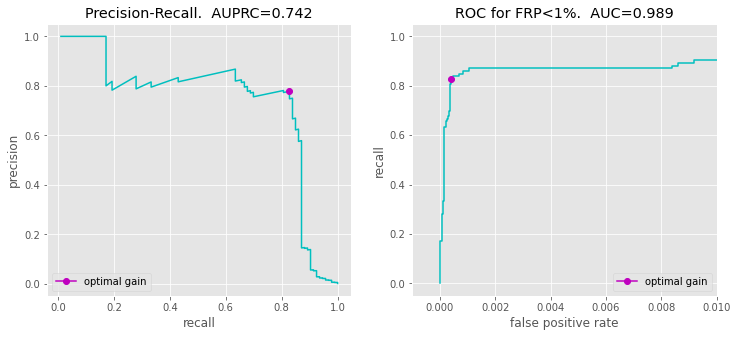

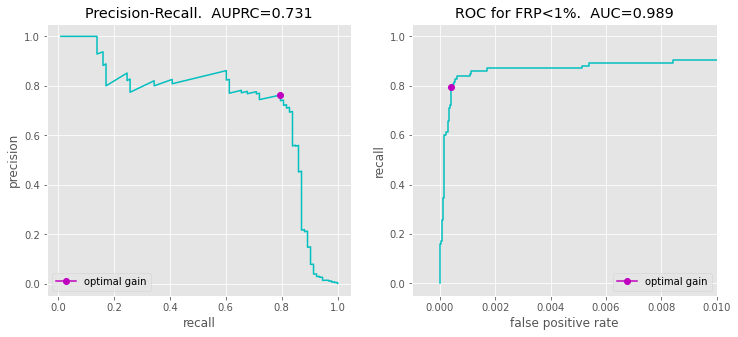

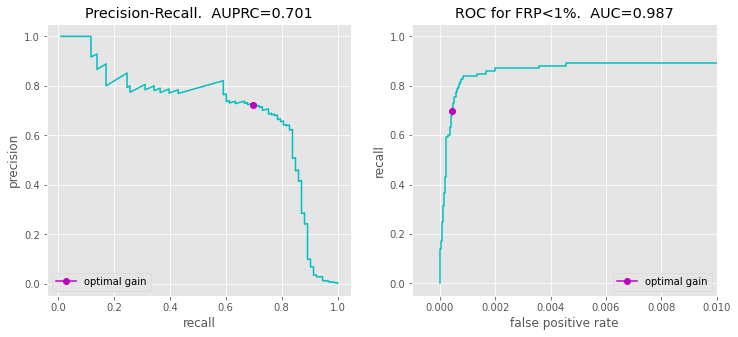

In [31]:
model = linear_model.LogisticRegression(penalty='l2', random_state=SEED)

for param in [0.001, 0.01, 0.1, 1]:
    model.set_params(C=param)
    model.fit(X_train, Y_train)

    Y_hat = model.predict_proba(X_test)[:,1]

    reports = pd.concat([reports, report(f'Logistic C={param}', Y_hat)])
    plot_classifier(Y_hat)

In [32]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,56849,20,15,78,0.985,0.747,0.598,0.798,0.849,0.000352
0,Logistic C=0.01,56847,22,17,76,0.989,0.742,0.567,0.778,0.828,0.000387
0,Logistic C=0.1,56846,23,20,73,0.989,0.731,0.538,0.763,0.796,0.000404
0,Logistic C=1,56845,24,28,65,0.987,0.701,0.441,0.722,0.699,0.000440


Conclusions from the Logistic Primer:
- Train set negatives:positives of G=1:1 is inferior to G=10:1
- Do not eliminate weakly correlated features
- Regularize! 
- AUPRC is better aligned with the business objective than AUC


### SVM

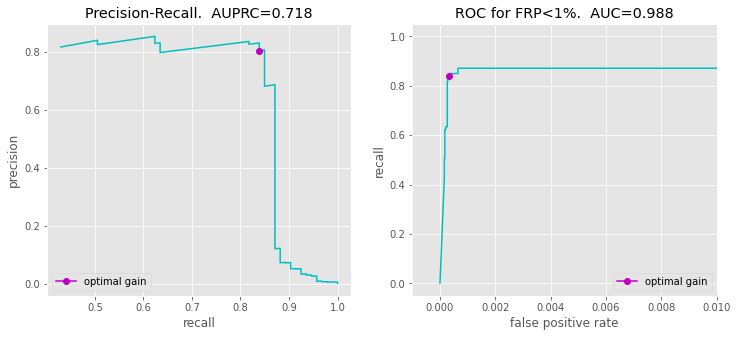

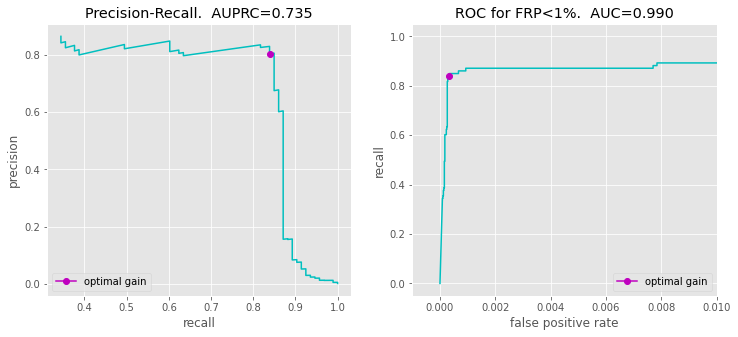

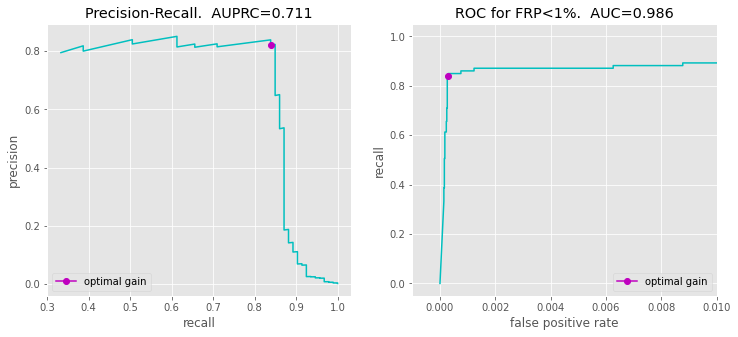

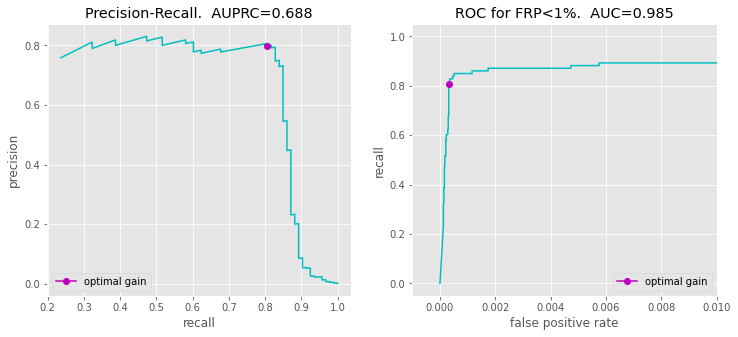

In [33]:
model = svm.SVC(kernel='poly', C=1, degree=1, probability=True, random_state=SEED)

for param in [0.01, 0.1, 1, 10]:
    model.set_params(C=param)
    model.fit(X_train, Y_train)

    Y_hat = model.predict_proba(X_test)[:,1]

    reports = pd.concat([reports, report(f'SVM C={param}', Y_hat)])
    plot_classifier(Y_hat)

In [34]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,56849,20,15,78,0.985,0.747,0.598,0.798,0.849,0.000352
0,Logistic C=0.01,56847,22,17,76,0.989,0.742,0.567,0.778,0.828,0.000387
0,Logistic C=0.1,56846,23,20,73,0.989,0.731,0.538,0.763,0.796,0.000404
0,Logistic C=1,56845,24,28,65,0.987,0.701,0.441,0.722,0.699,0.000440
0,SVM C=0.01,56851,18,15,78,0.988,0.718,0.612,0.804,0.839,0.000334
0,SVM C=0.1,56851,18,15,78,0.990,0.735,0.612,0.804,0.839,0.000334
0,SVM C=1,56853,16,15,78,0.986,0.711,0.613,0.821,0.839,0.000299
0,SVM C=10,56851,18,18,75,0.985,0.688,0.567,0.798,0.806,0.000334


### XGBoost

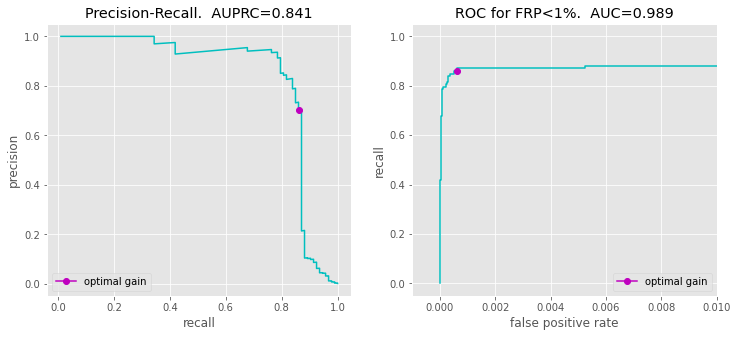

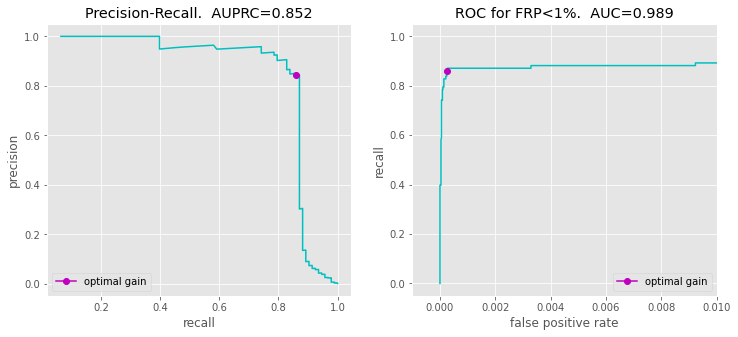

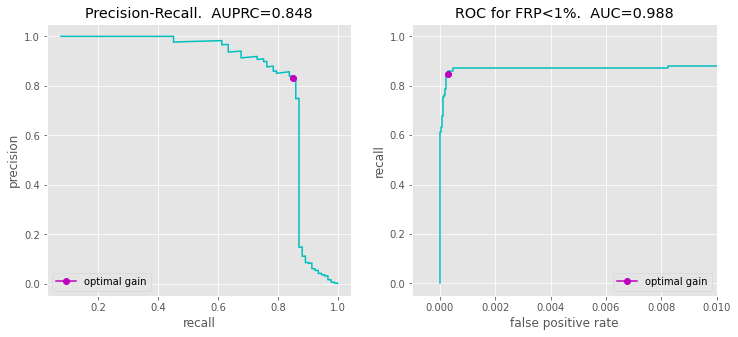

In [35]:
model= XGBClassifier(   max_depth=3, 
                        learning_rate=0.2,
                        n_estimators=2_000,
                        objective='binary:logistic',
                        subsample=0.75,
                        colsample_bylevel=0.75,
                        colsample_bytree=0.75,
                        gamma=0, 
                        min_child_weight=0, 
                        reg_alpha=0, 
                        reg_lambda=1, 
                        base_score=0.8, 
                        random_state=SEED, 
                     )

for param in [0.5, 0.75, 0.9]:
    
    model.set_params(subsample=param, colsample_bylevel=param, colsample_bytree=param)
    model.fit(X_train, Y_train)

    Y_hat = model.predict_proba(X_test)[:,1]

    reports = pd.concat([reports, report(f'XGBoost subsample={param}', Y_hat)])
    plot_classifier(Y_hat)


In [36]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,56849,20,15,78,0.985,0.747,0.598,0.798,0.849,0.000352
0,Logistic C=0.01,56847,22,17,76,0.989,0.742,0.567,0.778,0.828,0.000387
0,Logistic C=0.1,56846,23,20,73,0.989,0.731,0.538,0.763,0.796,0.000404
0,Logistic C=1,56845,24,28,65,0.987,0.701,0.441,0.722,0.699,0.000440
0,SVM C=0.01,56851,18,15,78,0.988,0.718,0.612,0.804,0.839,0.000334
0,SVM C=0.1,56851,18,15,78,0.990,0.735,0.612,0.804,0.839,0.000334
0,SVM C=1,56853,16,15,78,0.986,0.711,0.613,0.821,0.839,0.000299
0,SVM C=10,56851,18,18,75,0.985,0.688,0.567,0.798,0.806,0.000334
0,XGBoost subsample=0.5,56836,33,13,80,0.989,0.841,0.612,0.702,0.860,0.000598
0,XGBoost subsample=0.75,56855,14,13,80,0.989,0.852,0.621,0.842,0.860,0.000264


### Neural Network

In [37]:
EPOCHS     = 50
BATCH_SIZE = 256     # large batch size to include ~1/G positive samples

neg, pos = np.bincount(Y_train)
output_bias = np.log(pos/neg)

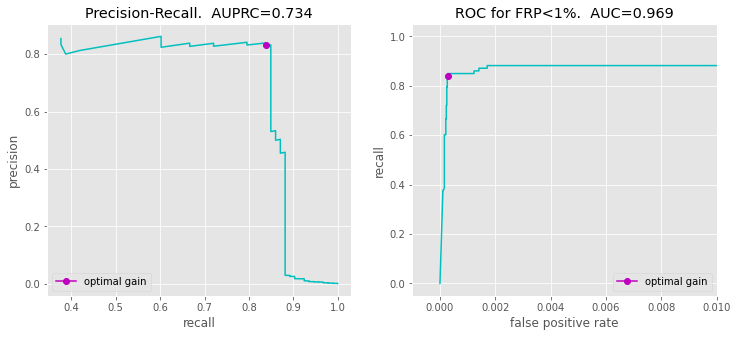

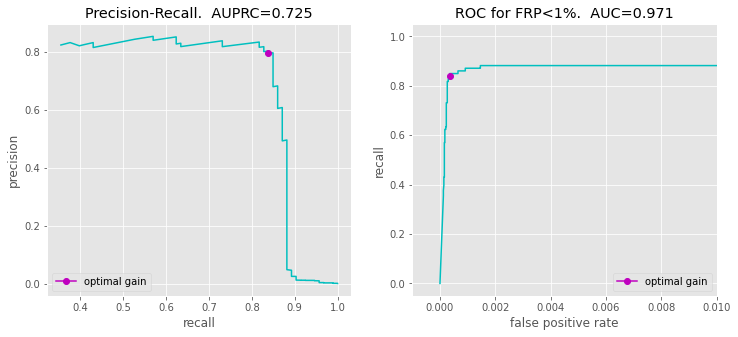

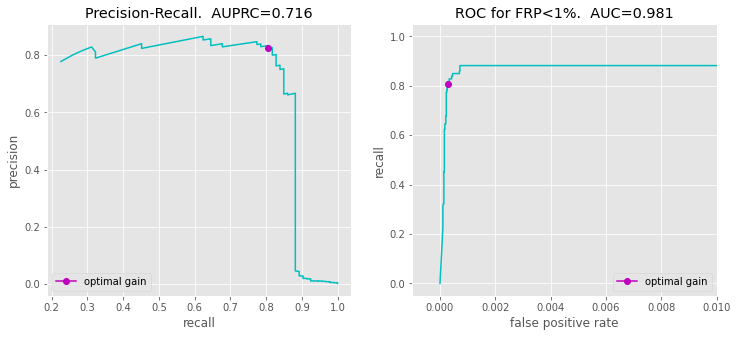

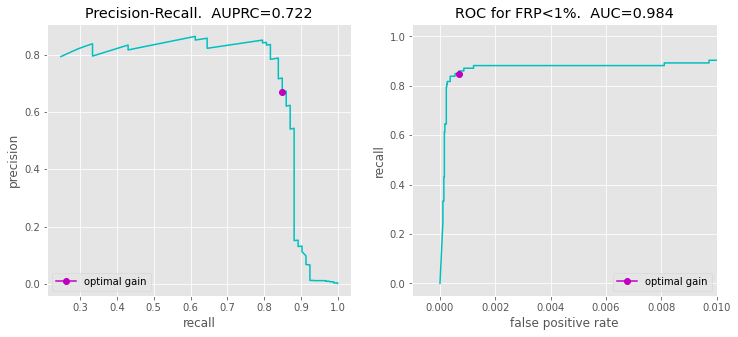

In [38]:
# simple fully-connected dense
for dim in [16, 32, 64, 128]:
    input = Input(shape=(X_train.shape[-1],), dtype=tf.int32)
    x = Dense(dim, activation='relu')(input)
    x = Dropout(0.5, seed=SEED)(x)
    output = Dense(1, activation='sigmoid', bias_initializer=Constant(output_bias))(x)
    model = Model(input, output)

    model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=[AUC(name='AUC'), AUC(curve='PR', name='AUPRC')])
    model.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=0)

    Y_hat = np.squeeze(model(X_test.values).numpy()) 

    reports = pd.concat([reports, report(f'Neural dim={dim}', Y_hat)])
    plot_classifier(Y_hat)


In [39]:
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,56849,20,15,78,0.985,0.747,0.598,0.798,0.849,0.000352
0,Logistic C=0.01,56847,22,17,76,0.989,0.742,0.567,0.778,0.828,0.000387
0,Logistic C=0.1,56846,23,20,73,0.989,0.731,0.538,0.763,0.796,0.000404
0,Logistic C=1,56845,24,28,65,0.987,0.701,0.441,0.722,0.699,0.000440
0,SVM C=0.01,56851,18,15,78,0.988,0.718,0.612,0.804,0.839,0.000334
0,SVM C=0.1,56851,18,15,78,0.990,0.735,0.612,0.804,0.839,0.000334
0,SVM C=1,56853,16,15,78,0.986,0.711,0.613,0.821,0.839,0.000299
0,SVM C=10,56851,18,18,75,0.985,0.688,0.567,0.798,0.806,0.000334
0,XGBoost subsample=0.5,56836,33,13,80,0.989,0.841,0.612,0.702,0.860,0.000598
0,XGBoost subsample=0.75,56855,14,13,80,0.989,0.852,0.621,0.842,0.860,0.000264


### Autoencoders

Extract features through an autoencoder network, apply best classifier to extracted features.

In [40]:
dim = 64

input = Input(shape=(X_train.shape[-1],), dtype=tf.int32)
x = Dense(dim, activation='tanh')(input)
x = Dense(16, activation='tanh')(x)  # the encoded representation
output = Dense(dim, activation='tanh')(x)
autoencoder = Model(input, output)
autoencoder.compile(optimizer=Adam(), loss='mse')
autoencoder.fit(X_train, Y_train, batch_size=BATCH_SIZE, epochs=100, verbose=0)

# extract features at the low-dimensional encoder layer
extractor = Model(inputs=autoencoder.input, outputs=autoencoder.layers[2].output)

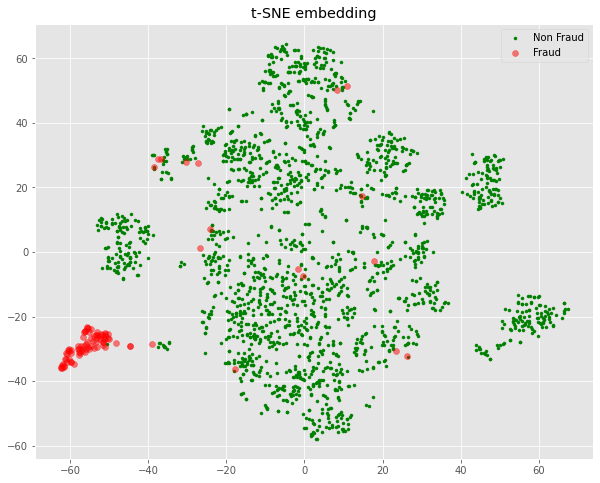

In [41]:
# Before autoencode
X_test_sub = X_test.copy()
X_test_sub['Class'] = Y_test
X_test_sub = pd.concat([X_test_sub[X_test_sub.Class==1], X_test_sub[X_test_sub.Class==0].sample(2_000, random_state=SEED)])
Y_test_sub = X_test_sub.pop('Class')

plot_tsne(tsne.fit_transform(X_test_sub), Y_test_sub)

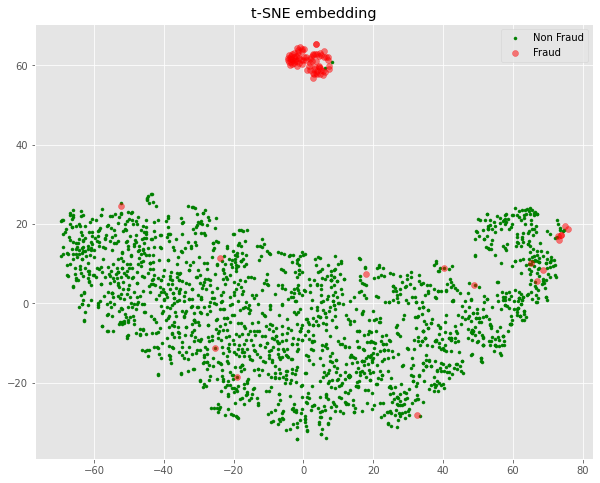

In [42]:
# After autoencode
X_encoded = np.squeeze(extractor(X_test_sub.values).numpy()) 

plot_tsne(tsne.fit_transform(X_encoded), Y_test_sub)

The two classes become more separable visually in a t-SNE embedding BUT false negatives (~15 red dots) still remain part of the green cloud. Performance of XGBoost did NOT improve when trained on the autoencoded features:

In [43]:
X_train_e = extractor(X_train.values)
X_train_e.shape

TensorShape([4389, 16])

In [44]:
X_test_e = np.squeeze(extractor(X_test.values).numpy()) 
X_test_e.shape

(56962, 16)

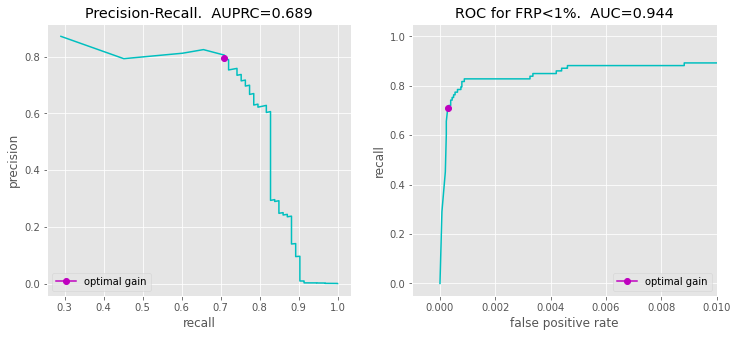

In [45]:
model= XGBClassifier(   max_depth=3, 
                        learning_rate=0.2,
                        n_estimators=2_000,
                        objective='binary:logistic',
                        subsample=0.75,
                        colsample_bylevel=0.75,
                        colsample_bytree=0.75,
                        gamma=0, 
                        min_child_weight=0, 
                        reg_alpha=0, 
                        reg_lambda=1, 
                        base_score=0.8, 
                        random_state=SEED, 
                     )

model.fit(X_train_e, Y_train)
Y_hat = model.predict_proba(X_test_e)[:,1]
reports = pd.concat([reports, report(f'Autoencoded+XGBoost', Y_hat)])
plot_classifier(Y_hat)

In [46]:
reports.index = range(len(reports))
reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,56849,20,15,78,0.985,0.747,0.598,0.798,0.849,0.000352
1,Logistic C=0.01,56847,22,17,76,0.989,0.742,0.567,0.778,0.828,0.000387
2,Logistic C=0.1,56846,23,20,73,0.989,0.731,0.538,0.763,0.796,0.000404
3,Logistic C=1,56845,24,28,65,0.987,0.701,0.441,0.722,0.699,0.000440
4,SVM C=0.01,56851,18,15,78,0.988,0.718,0.612,0.804,0.839,0.000334
5,SVM C=0.1,56851,18,15,78,0.990,0.735,0.612,0.804,0.839,0.000334
6,SVM C=1,56853,16,15,78,0.986,0.711,0.613,0.821,0.839,0.000299
7,SVM C=10,56851,18,18,75,0.985,0.688,0.567,0.798,0.806,0.000334
8,XGBoost subsample=0.5,56836,33,13,80,0.989,0.841,0.612,0.702,0.860,0.000598
9,XGBoost subsample=0.75,56855,14,13,80,0.989,0.852,0.621,0.842,0.860,0.000264


### Compare models

XGBoost shows the best performace **both in Recall and FPR.**

In [47]:
# Select the best classifiers from each class
best_reports = [0, 6, 9, 11]

best_reports = reports.iloc[best_reports]
best_reports

,classifier,TN,FP,FN,TP,AUC,AUPRC,max_gain,precision,recall,fpr
0,Logistic C=0.001,56849,20,15,78,0.985,0.747,0.598,0.798,0.849,0.000352
6,SVM C=1,56853,16,15,78,0.986,0.711,0.613,0.821,0.839,0.000299
9,XGBoost subsample=0.75,56855,14,13,80,0.989,0.852,0.621,0.842,0.860,0.000264
11,Neural dim=16,56854,15,15,78,0.969,0.734,0.614,0.830,0.839,0.000281


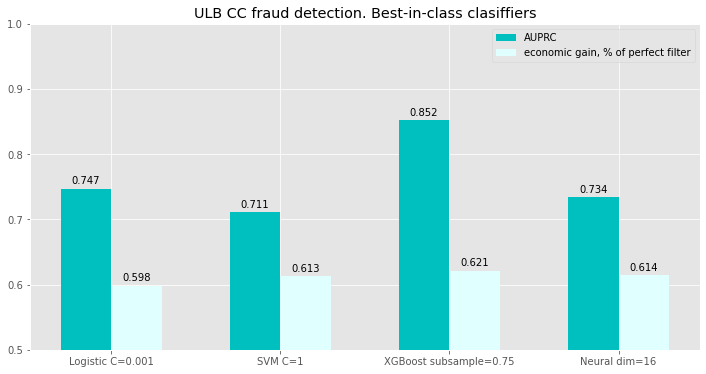

In [49]:
x = np.arange(len(best_reports))
width = 0.3

fig, ax = plt.subplots(figsize=(12, 6))
AUPRC = ax.bar(x-width/2, best_reports['AUPRC'].astype(float), width, label='AUPRC', color='c')
max_gain = ax.bar(x+width/2, best_reports['max_gain'].astype(float), width, 
                  label='economic gain, % of perfect filter', color='lightcyan')

ax.set_title('ULB CC fraud detection. Best-in-class clasiffiers')
ax.set_ylim(0.5,1)
ax.set_xticks(x)
ax.set_xticklabels(best_reports['classifier'])#, rotation=60)
ax.legend(loc='upper right')

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.3f}', xy=(rect.get_x()+.5*rect.get_width(), height), xytext=(0,3), 
                                     textcoords="offset points", ha='center', va='bottom')
autolabel(AUPRC)
autolabel(max_gain)
# fig.tight_layout()
plt.show()